# Import the libraries

In [121]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime, nltk, warnings
import matplotlib.cm as cm
import itertools
import pandas_profiling
from IPython.display import display, HTML
init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
# mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
%matplotlib inline

# Import the Dataset

In [2]:
df = pd.read_csv('data.csv', encoding='ISO-8859-1')

In [3]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [4]:
df.shape

(541909, 8)

In [5]:
# lowercase the columns
df.columns = map(str.lower, df.columns)

In [6]:
# drop the duplicates entries
customer_by_country = df[['country', 'customerid']].drop_duplicates()

In [7]:
# country-wise customers
customer_by_country.groupby(['country'])['customerid'].count().reset_index().sort_values('customerid', ascending=False)

,country,customerid
36,United Kingdom,3950
14,Germany,95
13,France,87
31,Spain,31
3,Belgium,25
33,Switzerland,21
27,Portugal,19
19,Italy,15
12,Finland,12
1,Austria,11


In [8]:
#drop every country except, UK has more than 90 percent of the customers
df = df.query("country=='United Kingdom'").reset_index(drop= True)

In [9]:
df.head()

,invoiceno,stockcode,description,quantity,invoicedate,unitprice,customerid,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [10]:
# missing values
df.isna().sum()

invoiceno           0
stockcode           0
description      1454
quantity            0
invoicedate         0
unitprice           0
customerid     133600
country             0
dtype: int64

In [11]:
# remove entries with no customerid
df = df[pd.notnull(df['customerid'])]

In [12]:
df.shape

(361878, 8)

In [13]:
# validate if there is any -ve value in the quantity column
df['quantity'].min()

-80995

In [14]:
# validate if there is any -ve value in the unitprice column
df['unitprice'].min()

0.0

In [15]:
# filter records with -ve quantity
df = df[(df['quantity']>0)]

In [16]:
# invoice date to datetime format
df['invoicedate'] = pd.to_datetime(df['invoicedate'])

In [17]:
# new column - Total
df['total'] = df['unitprice']*df['quantity']

In [18]:
df.shape

(354345, 9)

In [19]:
df.head()

,invoiceno,stockcode,description,quantity,invoicedate,unitprice,customerid,country,total
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


# Customer Segmentation

## RFM Analysis

In [21]:
#  set the latest date to 2011-12-10 as last invoice date was 2011-12-09.
# this is to calculate the number of days from recent purchase
latest_date = dt.datetime(2011,11,10)

In [22]:
# rfm modeling score for each customer 
rfm_scores = df.groupby('customerid').agg({'invoicedate': lambda x : (latest_date-x.max()).days, 'invoiceno': lambda x:  len(x), 'total':lambda x: x.sum()})

In [23]:
#  convert the invoice date to int
rfm_scores['invoicedate'] = rfm_scores['invoicedate'].astype(int)

In [24]:
# rename the columns to recency, frequency and monetary
rfm_scores.rename(columns= {
    'invoicedate': 'recency',
    'invoiceno' : 'frequency',
    'total' : 'monetary'}, inplace=True)

In [25]:
rfm_scores.reset_index().head()

,customerid,recency,frequency,monetary
0,12346.0,295,1,77183.60
1,12747.0,-28,103,4196.01
2,12748.0,-30,4596,33719.73
3,12749.0,-27,199,4090.88
4,12820.0,-27,59,942.34


In [29]:
# save the rfm scores
rfm_scores.to_csv('rfm_scores.csv')

### Recency

In [26]:
rfm_scores.recency.describe()

count    3921.000000
mean       61.722265
std        99.528532
min       -30.000000
25%       -13.000000
50%        20.000000
75%       112.000000
max       343.000000
Name: recency, dtype: float64

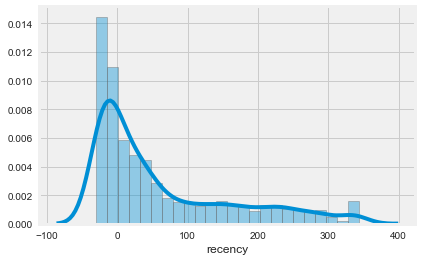

In [27]:
# recency distribution plot
ax = sns.distplot(rfm_scores['recency'])

### Frequency

In [122]:
# frequency - descriptive statistics
rfm_scores.recency.describe()

count    3921.000000
mean       61.722265
std        99.528532
min       -30.000000
25%       -13.000000
50%        20.000000
75%       112.000000
max       343.000000
Name: recency, dtype: float64

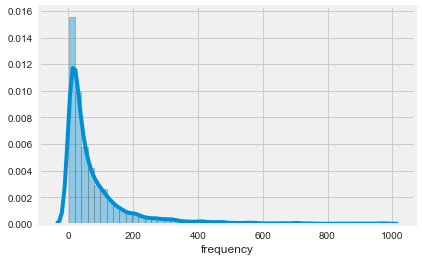

In [51]:
# distribution plot of the frequency column
ax1 = sns.distplot(rfm_scores.query('frequency<1000')['frequency'])

### Monetary

In [53]:
# monetary - descriptive statistics
rfm_scores.monetary.describe()

count      3921.000000
mean       1863.910113
std        7481.922217
min           0.000000
25%         300.040000
50%         651.820000
75%        1575.890000
max      259657.300000
Name: monetary, dtype: float64

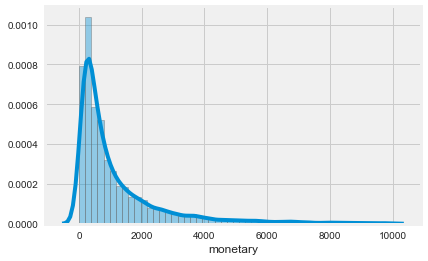

In [57]:
# distribution plot of the monetary columns
ax3 = sns.distplot(rfm_scores.query('monetary<10000')['monetary'])

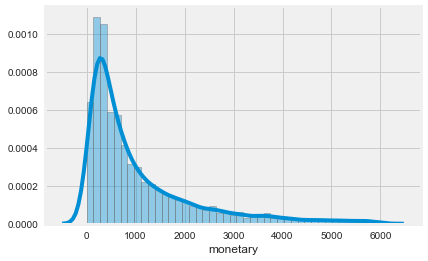

In [62]:
# distribution plot of the monetary < 6000
ax4 = sns.distplot(rfm_scores.query('monetary<6000')['monetary'])

## Split the customers

### Divide the rfm_scores.csv into four segments

In [65]:
# split into four segments using quantiles
quantile = rfm_scores.quantile(q=[0.25, 0.5, 0.75])
quantile= quantile.to_dict()

In [66]:
quantile

{'recency': {0.25: -13.0, 0.5: 20.0, 0.75: 112.0},
 'frequency': {0.25: 17.0, 0.5: 41.0, 0.75: 99.0},
 'monetary': {0.25: 300.03999999999996, 0.5: 651.8199999999999, 0.75: 1575.89}}

### R, F and M Scorings

In [68]:
# functions to create R, F,M segments

def RScoring(x,p,d):
    """
    RScoring is used to calculate the recency of any customer
    
    x : scoring parameter
    d : dataframe
    p : column of the dataframe
    
    
    recency is inversly proportional to the Rscoring
    
    lower the value, more engage/loyal the customer is 
    higher the value, less engage/loyal the customer is
    
    
    """
    if x <= d[p][0.25]:
        return 1
    elif x<= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]:
        return 3
    else:
        return 4

In [83]:
def FnMScoring(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]:
        return 2
    else:
        return 1
        """
    FnMScoring is used to calculate the frequency and monetary value of any customer
    
    x : scoring parameter
    d : dataframe
    p : column of the dataframe
    
    
    frequency and monetary is directly proportional to the FnMscoring
    
    higher the value, more engage/loyal the customer is 
    lower the value, less engage/loyal the customer is
    
    
    """
    

### new Columns - R, F, M 

In [91]:
# calculate Add R, F, M segments values oclumns in the existing dataset to R, F, M segments values
rfm_scores['R'] = rfm_scores['recency'].apply(RScoring, args=('recency', quantile))
rfm_scores['F'] = rfm_scores['frequency'].apply(FnMScoring, args = ('frequency', quantile))
rfm_scores['M'] = rfm_scores['monetary'].apply(FnMScoring, args = ('monetary', quantile))

In [92]:
rfm_scores

,recency,frequency,monetary,R,F,M
customerid,,,,,,
12346.0,295,1,77183.60,4,4,1
12747.0,-28,103,4196.01,1,1,1
12748.0,-30,4596,33719.73,1,1,1
12749.0,-27,199,4090.88,1,1,1
12820.0,-27,59,942.34,1,2,2
...,...,...,...,...,...,...
18280.0,247,10,180.60,4,4,4
18281.0,150,7,80.82,4,4,4
18282.0,-23,12,178.05,1,4,4


### Create RFMGroup for easy refernce

In [93]:
# calculate and add rfmGroup showing combined values of R, F,M  values
rfm_scores['RFMgroup'] = rfm_scores.R.map(str) + rfm_scores.F.map(str) + rfm_scores.M.map(str)

In [123]:
rfm_scores.RFMgroup

customerid
12346.0    441
12747.0    111
12748.0    111
12749.0    111
12820.0    122
          ... 
18280.0    444
18281.0    444
18282.0    144
18283.0    111
18287.0    221
Name: RFMgroup, Length: 3921, dtype: object

### Calculate the RFMScore

In [110]:
# add the columns R, F, M for total rfm score
rfm_scores['RFMScore'] = rfm_scores[['R', 'F', 'M']].sum(axis=1)

# more the RFMScore, less engage/loyal the customer is
# less the RFMScore, more engage/loyal the customer is

In [111]:
rfm_scores

,recency,frequency,monetary,R,F,M,RFMgroup,RFMScore
customerid,,,,,,,,
12346.0,295,1,77183.60,4,4,1,441,9
12747.0,-28,103,4196.01,1,1,1,111,3
12748.0,-30,4596,33719.73,1,1,1,111,3
12749.0,-27,199,4090.88,1,1,1,111,3
12820.0,-27,59,942.34,1,2,2,122,5
...,...,...,...,...,...,...,...,...
18280.0,247,10,180.60,4,4,4,444,12
18281.0,150,7,80.82,4,4,4,444,12
18282.0,-23,12,178.05,1,4,4,144,9


#### Different segments of the customers

In [118]:
rfm_scores.RFMScore.value_counts().sort_index()

3     409
4     345
5     386
6     380
7     408
8     393
9     425
10    470
11    362
12    343
Name: RFMScore, dtype: int64

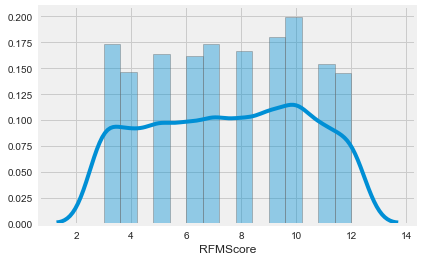

In [115]:
sns.distplot(rfm_scores.RFMScore)

### Define Loyalty

In [114]:
# assign the loyalty level to the customers
loyalty_level = ['Platinum', 'Gold', 'Silver', "Bronze"]
score_cuts = pd.qcut(rfm_scores['RFMScore'], q=4, labels=loyalty_level)
rfm_scores['loyalty'] = score_cuts.values
rfm_scores

,recency,frequency,monetary,R,F,M,RFMgroup,RFMScore,loyalty
customerid,,,,,,,,,
12346.0,295,1,77183.60,4,4,1,441,9,Silver
12747.0,-28,103,4196.01,1,1,1,111,3,Platinum
12748.0,-30,4596,33719.73,1,1,1,111,3,Platinum
12749.0,-27,199,4090.88,1,1,1,111,3,Platinum
12820.0,-27,59,942.34,1,2,2,122,5,Platinum
...,...,...,...,...,...,...,...,...,...
18280.0,247,10,180.60,4,4,4,444,12,Bronze
18281.0,150,7,80.82,4,4,4,444,12,Bronze
18282.0,-23,12,178.05,1,4,4,144,9,Silver


In [119]:
# validate the data for RFMgroup ==111
rfm_scores[rfm_scores['RFMgroup'] == '111'].sort_values('monetary', ascending = False).reset_index()

,customerid,recency,frequency,monetary,R,F,M,RFMgroup,RFMScore,loyalty
0,18102.0,-30,431,259657.30,1,1,1,111,3,Platinum
1,17450.0,-22,337,194550.79,1,1,1,111,3,Platinum
2,17511.0,-28,963,91062.38,1,1,1,111,3,Platinum
3,16684.0,-26,277,66653.56,1,1,1,111,3,Platinum
4,14096.0,-26,5111,65164.79,1,1,1,111,3,Platinum
...,...,...,...,...,...,...,...,...,...,...
404,14759.0,-26,102,1625.97,1,1,1,111,3,Platinum
405,16987.0,-27,129,1625.05,1,1,1,111,3,Platinum
406,15172.0,-22,110,1624.05,1,1,1,111,3,Platinum
407,14178.0,-22,327,1620.93,1,1,1,111,3,Platinum


## save the loyalty dataframe


In [126]:
rfm_scores.to_csv('RFMAnalysis_loyal_customers.csv')